In [10]:
using Distributions;
using PyPlot;
using BlackBoxOptim;
using DataFrames;

# Exercício 1: 
Considere o modelo padrão de crescimento econômico em que $\delta=1$, ou seja, o capital se deprecia completamente a cada período. Suponha que existe uma massa unitária de agentes que desconta o futuro a uma taxa $\beta \in (0,1)$, vive eternamente e tem preferências do tipo $u(c)=\log{(c)}$. A função de produção é dada por
\begin{equation}
    Y_t = e^{z_t}K_t^\alpha
\end{equation}
em que $K_t$ é o estoque de capital, $\alpha>0$ e
\begin{equation}
    z_t = (1-\rho)\lambda + \rho z_{t+1} + \epsilon, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)\forall t.
\end{equation}
Então o problema sequencial do planejador é dado por
\begin{equation}
\underset{\{C_t, K_{t+1}\}^\infty_{t=0}}{Max} \mathbb{E}_0 \sum_{t=0}^\infty \beta u(C_t), \quad u(C_t) = ln(C_t) \tag{SP}
\end{equation}
s. t.
\begin{align}
&C_t + K_{t+1} \leq exp(z_t)K^\alpha_t, \\
&C_t > 0,\quad K_t > 0.
\end{align}
Pede-se:
## (a)
Escreva o problema funcional (eq. de Bellman) do planejador.
Formulação em programação dinâmica

Equação de Belman

\begin{align} 
    \mathbf{V}(z_t, K_t) &= \underset{C_t\in\mathbf{\Gamma}(z_t, K_t)}{\sup} \left\{ \log(C_t) + \beta \mathbb{E}_t\mathbf{V}(z_{t+1}, K_{t+1}) \right\}, \tag{FE}\\
    \mathbf{\Gamma}(z_t, K_t) &= \left\{ {x\in\mathbb{R}_+: x\leq\exp{(z_t)}K_t^\alpha-K_{t+1}} \quad \text{ e } \quad K_t\in\mathbb{R}_+ \right\}
\end{align}
reescrevendo em termos de $K_{t+1}$ temos a Equação de Bellman do planejador
\begin{align} 
        \mathbf{V}(z_t, K_t) = \underset{K_t\in\mathbb{R}_+}{\sup} \left\{ \log\left(e^{z_t}K_t^\alpha-K_{t+1}\right) + \beta\mathbf{V}\left(z_{t+1},K_{t+1}\right) \right\}
\end{align}
assumindo $\mathbf{V}(\cdot)$ é diferenciável, a condição de primeira ordem com respeito a $K_{t+1}$ é
\begin{align}
    \frac{\partial\mathbf{V}(z_t,K_t)}{\partial K_{t+1}} = \frac{\partial u\left(e^{z_t}K_t^\alpha-K_{t+1}\right)}{\partial K_{t+1}} + \beta \frac{\partial \mathbf{V}(z_{t+1}, K_{t+1}) }{\partial K_{t+1}} = 0 \tag{FOC} \\
\end{align}
condição de envelope:
\begin{align}
    \frac{\partial\mathbf{V}(z_t,K_t)}{\partial K_{t}} &= \frac{1}{e^{z_{t+1}}K^\alpha_{t+1}-K_{t+2}}\alpha e^{z_{t+1}}K^{\alpha-1}_{t+1} \tag{BS}
\end{align}
substituting \eqref{eq:BS} into \eqref{eq:FOC}
\begin{align}
    -\frac{1}{e^{z_t}K^\alpha_t-K_{t+1}} + \frac{1}{e^{z_{t+1}}K^\alpha_{t+1}-K_{t+2}}\alpha e^{z_{t+1}}K^{\alpha-1}_{t+1} = 0
\end{align}
temos a equação de euler
\begin{align}
    \frac{1}{c_t} = \beta  \frac{ e^{z_{t+1}} \alpha K^{\alpha-1}_{t+1} }{ c_{t+1} }\label{eq:EUL} \tag{EUL}
\end{align}
#### (c) Use o seguinte guess $C_t = AY_t$ para a função política do consumo. Encontre $A$ e expresse a função política do consumo e do capital.
Suponha a forma para a função política do consumo: $C_t = A\left(e^{z_t}K^\alpha_t\right)$. Como $C_t = Y_t - K_{t+1}$, então $K_{t+1} = (1-A)Y_t$. Reorganizando \eqref{eq:EUL}:
\begin{equation}
    \frac{K_{t+1}}{C_t} = \alpha\beta\frac{ e^{z_{t+1}} K^\alpha_{t+1}}{C_{t+1}}
\end{equation}
Pela nossa conjectura sobre a função política do consumo temos que
\begin{equation}
    \frac{(1-A)}{A}=\alpha\beta\frac{ e^{z_{t+1}} K^\alpha_{t+1}}{C_{t+1}}
\end{equation}
Também Para o consumo um passo a frente
\begin{equation}
    \frac{(1-A)}{A}=\alpha\beta\frac{ e^{z_{t+1}} K^\alpha_{t+1}}{A e^{z_{t+1}} K^\alpha_{t+1}}
\end{equation}
Portanto
\begin{equation}
    (1-A) = \alpha\beta
\end{equation}
A função política do consumo é portanto
\begin{equation}
    C_t = (1-\alpha\beta)e^{z_{t}} K^\alpha_{t}. 
\end{equation}
Pela já explorada simetria $Y_t = C_t + K_{t+1}$,
\begin{equation}
    K_{t+1} = \alpha\beta e^{z_{t}} K^\alpha_{t}. 
\end{equation}

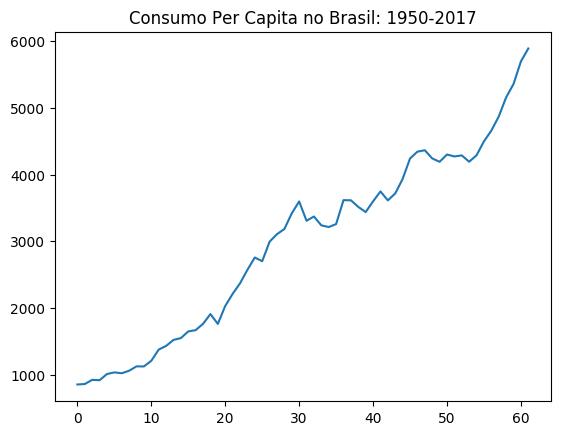

In [2]:
df_c = readtable("consumo_smm.csv");
plot(df_c[2]);
title("Consumo Per Capita no Brasil: 1950-2017");

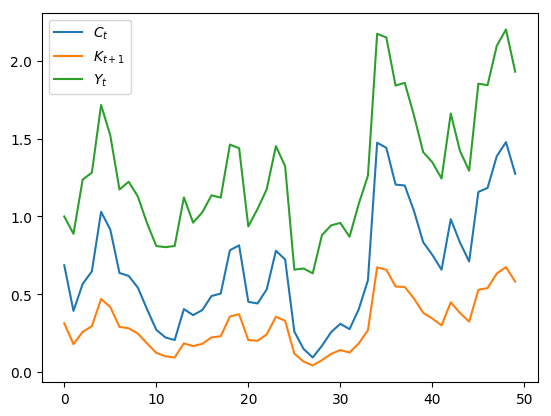

In [20]:
function pol_C(α, β, zₜ, Kₜ)
    Cₜ = (1 - α*β)*exp(zₜ)*Kₜ^α
    return Cₜ
end
#
function pol_Kp(α, β, zₜ, Kₜ)
    Kₜ₊₁ = α*β*exp(zₜ)*Kₜ^α
    return Kₜ₊₁
end
#
function Simul_Paths(α::Float64, β::Float64, ρ::Float64, shocks::Vector{Float64}; moms::Bool=false)
    #essa função calcula as trajetórias de C, Kp e Y, dados α, β, e ρ. (retorna os momentos de interesse se moms == true)
    λ = 0.00
    K₀ = 1.0
    T = length(shocks)
    z = Vector{Float64}(T)
    C = Vector{Float64}(T)
    Kp = Vector{Float64}(T)
    Y = Vector{Float64}(T)
    z[1] = 0.0 # valor inicial do choque tecnológico
    C[1] = (1 - α*β)*exp(z[1])*K₀^α # valor inicial do consumo
    Kp[1] = α*β*exp(z[1])*K₀^α # valor inicial do capital um passo a frente
    Y[1] = exp(z[1])^K₀^α # valor inicial do produto 
    for t ∈ 2:T
        z[t] = λ*(1-ρ) + ρ*z[t-1] + shocks[t] # sorteado choque de produtividade
        C[t] = pol_C(α, β, z[t], Kp[t-1]) # consumo pela função política
        Kp[t] = pol_Kp(α, β, z[t], Kp[t-1]) # capital pela função política
        Y[t] = exp(z[t])^Kp[t-1]^α # produto pela função de produção
    end
    (moms == false) && (return C, Kp, Y) # se moms==false, retorna as trajetórias e a função termina aqui.
    moms = zeros(3) # se moms==true a função continua e retorna os momentos
    moms[1] = mean(diff(log.(C)))
    moms[2] = mean(diff(log.(Y)))
    moms[3] = sum(mean(C./Y))
    return moms
end;
T = 50; σ² = 0.1; σ = √σ²;
shocks = rand(Normal(0.0, σ), T);
α₀ = 0.33; β₀ = 0.95; ρ₀ = .9;
_C, _Kp, _Y = Simul_Paths(α₀, β₀, ρ₀, shocks);
plot(_C, label=L"$C_t$"); plot(_Kp, label=L"$K_{t+1}$"); plot(_Y, label=L"$Y_t$");
legend();


#### (d) Suponha que $\lambda = 0$, $z_0 = 0$, $\sigma^2=0.1$ e $K_0 = 1.0$. Estime os parâmetros $(\alpha,\beta,\rho)$ com ométodo dos momentos simulados (SMM), utilizando como momentos dos dados
\begin{equation}
\mu[y_T] = \left[ \frac{1}{T}\sum_t^T\frac{\Delta\tilde{C_t}}{\tilde{C_t}}, \frac{1}{T}\sum_t^T\frac{\Delta\tilde{Y_t}}{\tilde{Y_t}}, \sum_t^T\frac{\tilde{C}_t}{\tilde{Y}_t} \right ]
\end{equation}
com momentos amostrais $\mu[y_T] = [0.055, 0.0489, 0.8165]$. Em que $\tilde{C}_t$ é o consumo per capita brsileiro, $\tilde{Y}$ é a renda disponível per capita brasileira e $\Delta x = x_{t+1} - x_t$.

Dicas:

Repita a estimação com SMM
\begin{itemize}
    \item Utilize como horizonte temporal T = 50.
    \item Repita a estimação com SMM para $S \in \{10, 100, 1000, 10000\}$ e compare os resultados.
\end{itemize}

#### (e) Repita a estimação para T = 100: Como esta mudança afeta a estimação dos parâmetros?
Veremos abaixo que a estimação dos parâmetros não é satisfatória
#### (f) Apresente séries de consumo geradas pelo modelo e compare com os dados de consumo per capita do Brasil.
Apresentamos a série para o consumo do brasil. É evidente que o modelo considerado aqui não é capaz de produzir uma dinâmica similar.

In [12]:
# simularemos a economia por T períodos, S vezes, e então calcularemos os momentos de interesse.
function SimMoms(Pars, shocks::Array{Float64,})
    α = Pars[1]
    β = Pars[2]
    ρ = Pars[3]
    #(α < 0.0) && return Inf
    #(α > 1.0) && return Inf
    #(β > 1.0) && return Inf
    #(β < 0.0) && return Inf
    #(abs(ρ) > 1.0) && return Inf
    T, S = size(shocks)
    moms_sim = Array{Float64}(length(Pars), S)
    for iS ∈ 1:S
        moms_sim[:, iS] = Simul_Paths(α, β, ρ, shocks[:, iS], moms=true)
    end
    moms = mean(moms_sim ,2)
    W = eye(length(moms))
    m_obs = [0.055; 0.0489; 0.8165]
    erro = moms - m_obs 
    dist = moms'*W*moms
    return dist
end
# função que calcula os choques 
function wrap_SimMoms(Pars, T::Int64, S::Int64)
    srand(123)
    shocks = rand(Normal(0.0, σ), T, S)
    out = SimMoms(Pars, shocks)
    return out[1]
end
# valores iniciais "bonitos"
init_vals = [0.25; 0.95; 0.9];

In [24]:
srch_rng = [(.05, 0.70), (.8, .99), (.8, .99)] # procurar só valores "plausíveis" para os parâmetros
res_t50_s100 = bboptimize(Pars -> wrap_SimMoms(Pars, 50, 100); NumDimensions = 3,SearchRange = srch_rng, iterations = 100);
res_t50_s1000 = bboptimize(Pars -> wrap_SimMoms(Pars, 50, 1000); SearchRange = srch_rng, NumDimensions = 3, iterations = 100);
res_t100_s100 = bboptimize(Pars -> wrap_SimMoms(Pars, 100, 100); SearchRange = srch_rng, NumDimensions = 3, iterations = 100);
res_t100_s1000 = bboptimize(Pars -> wrap_SimMoms(Pars, 100, 1000); SearchRange = srch_rng, NumDimensions = 3, iterations = 100);

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 160 evals, 157 steps, improv/step: 0.510 (last = 0.5096), fitness=0.025424720
1.00 secs, 329 evals, 327 steps, improv/step: 0.349 (last = 0.2000), fitness=0.024843064
1.50 secs, 497 evals, 494 steps, improv/step: 0.231 (last = 0.0000), fitness=0.024843064
2.00 secs, 667 evals, 664 steps, improv/step: 0.172 (last = 0.0000), fitness=0.024843064
2.50 secs, 837 evals, 834 steps, improv/step: 0.137 (last = 0.0000), fitness=0.024843064
3.01 secs, 1007 evals, 1004 steps, improv/step: 0.114 (last = 0.0000), fitness=0.024843064
3.51 secs, 1179 evals, 1176 steps, improv/step: 0.097 (last = 0.0000), fitness=0.024843064
4.01 secs, 1351 evals, 1348 steps, improv/step: 0.085 (last = 0.0000), fitness=0.024843064
4.51 secs, 152

In [25]:
function plot_paths_smm(res_1000, titl="smm"; T=20)
    pars_1000 = res_1000.archive_output.best_candidate
    σ² = 0.01; σ = √σ²
    shocks = rand(Normal(0.0, σ), T)
    α₀ = pars_1000[1]; β₀ = pars_1000[2]; ρ₀ = pars_1000[3]
    _C, _Kp, _Y = Simul_Paths(α₀, β₀, ρ₀, shocks)
        figure()
    plot(_C, label=L"$C_t$"); plot(_Kp, label=L"$K_{t+1}$"); plot(_Y, label=L"$Y_t$"); 
    suptitle(titl);title("α = $(round(α₀,2)), β = $(round(β₀,2)), ρ = $(round(ρ₀,2))");legend();
end

plot_paths_smm (generic function with 2 methods)

In [26]:
### Agora plotaremos as "profile-likelihoods" para ter noção de como os resultados estão instáveis.
function plot_stuf(res; titl="smm", T=50)
    nsim = 1000
    #T = 100
    (α, β, ρ) = res.archive_output.best_candidate
    α_grid = collect(linspace(.05, 0.70, 100))
    profile_α = similar(α_grid)
    for iα in 1:length(α_grid)
        profile_α[iα] = wrap_SimMoms([α_grid[iα]; β; ρ], T, nsim)
    end
    β_grid = collect(linspace(0.8, 0.99, 100))
    profile_β = similar(β_grid)
    for iβ in 1:length(β_grid)
        profile_β[iβ] = wrap_SimMoms([α; β_grid[iβ]; ρ], T, nsim)
    end
    ρ_grid = collect(linspace(0.8, 0.99, 100))
    profile_ρ = similar(ρ_grid)
    for iρ in 1:length(ρ_grid)
        profile_ρ[iρ] = wrap_SimMoms([α; β; ρ_grid[iρ] ], T, nsim)
    end
    figure()
    suptitle(titl)
    plot(α_grid, -log.(profile_α))
    title(L"$\alpha$")
    figure()
    plot(β_grid, -log.(profile_β))
    title(L"$\beta$")
    figure()
    plot(ρ_grid, -log.(profile_ρ))
    title(L"$\rho$");
    return α_grid, β_grid, ρ_grid, profile_α, profile_β, profile_ρ
end

plot_stuf (generic function with 1 method)

In [ ]:
#srch_rng = [(.05, 0.70), (.8, .99), (.8, .99)] # procurar só valores "plausíveis" para os parâmetros
#res_t50_s100 = bboptimize(Pars -> wrap_SimMoms(Pars, 50, 100); NumDimensions = 3,SearchRange = srch_rng, iterations = 100);
#res_t50_s1000 = bboptimize(Pars -> wrap_SimMoms(Pars, 50, 1000); SearchRange = srch_rng, NumDimensions = 3, iterations = 100);
#res_t100_s100 = bboptimize(Pars -> wrap_SimMoms(Pars, 100, 100); SearchRange = srch_rng, NumDimensions = 3, iterations = 100);
#res_t100_s1000 = bboptimize(Pars -> wrap_SimMoms(Pars, 100, 1000); SearchRange = srch_rng, NumDimensions = 3, iterations = 100);

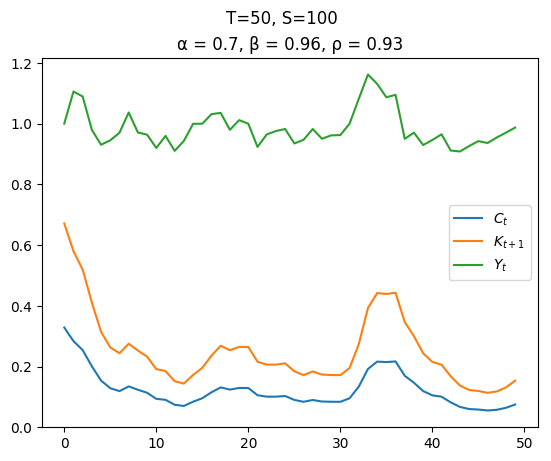

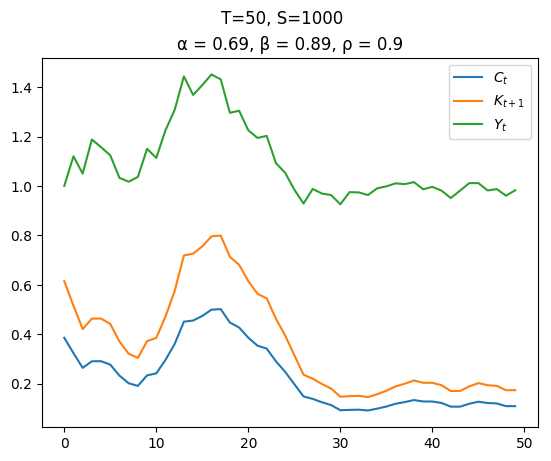

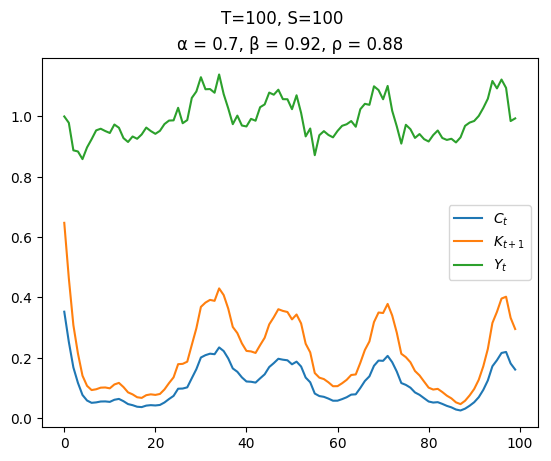

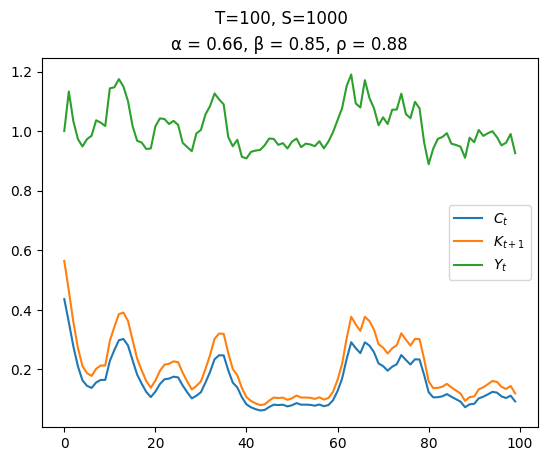

In [27]:
plot_paths_smm(res_t50_s100, "T=50, S=100"; T=50);
plot_paths_smm(res_t50_s1000, "T=50, S=1000"; T=50);
plot_paths_smm(res_t100_s100, "T=100, S=100"; T=100);
plot_paths_smm(res_t100_s1000, "T=100, S=1000"; T=100);

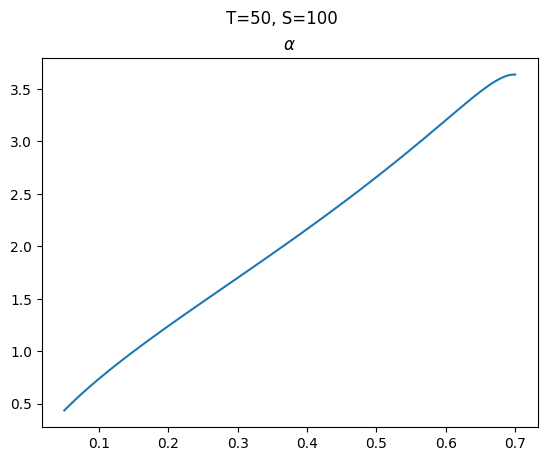

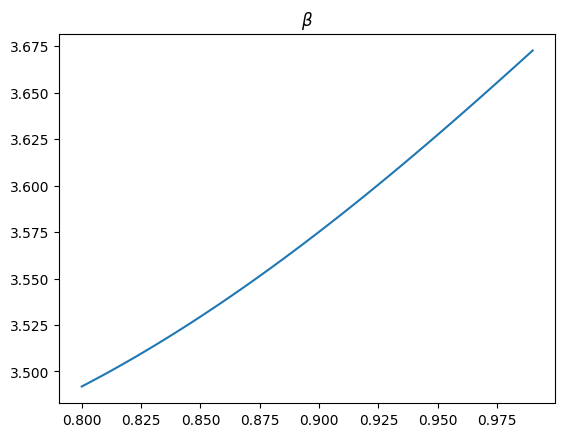

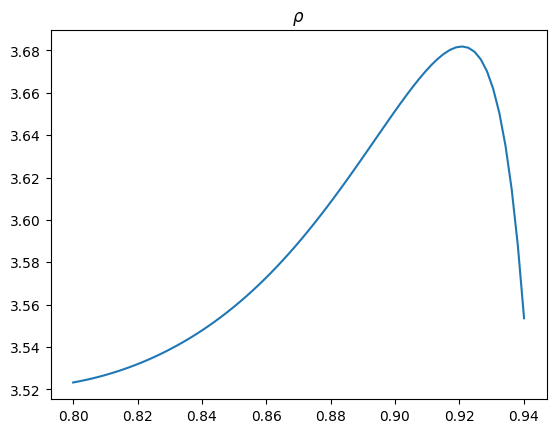

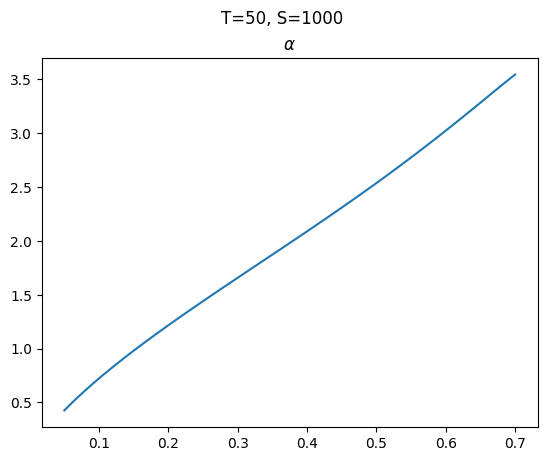

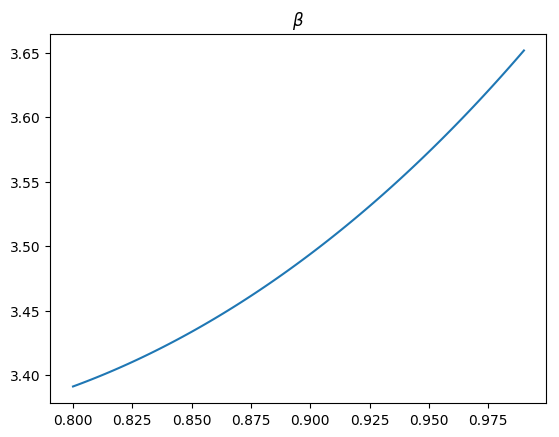

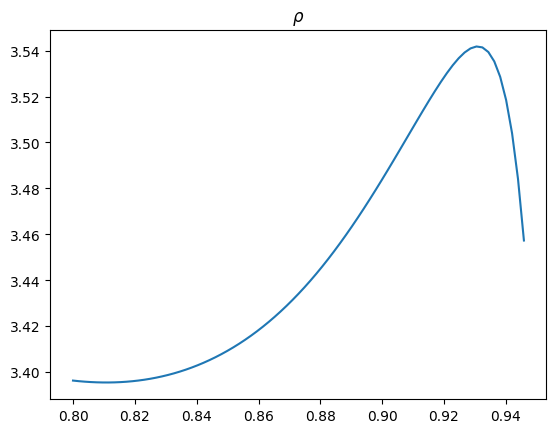

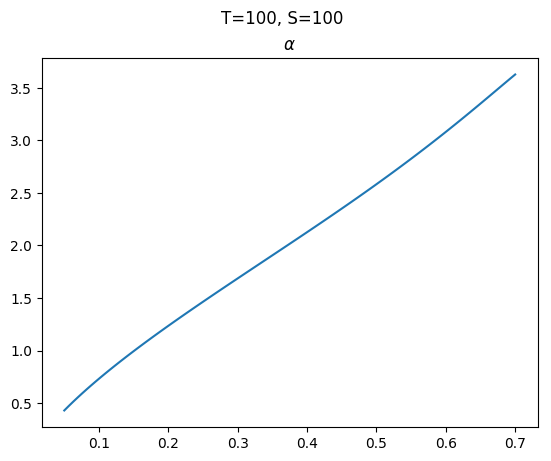

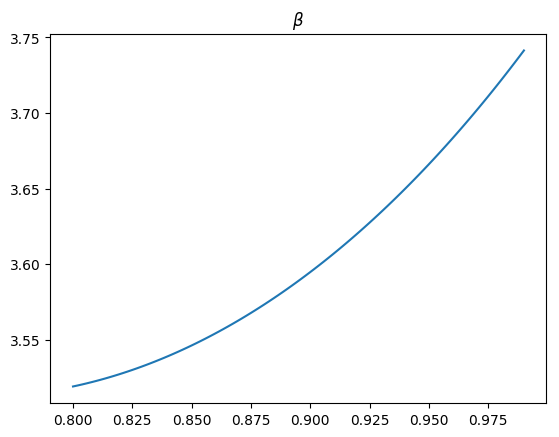

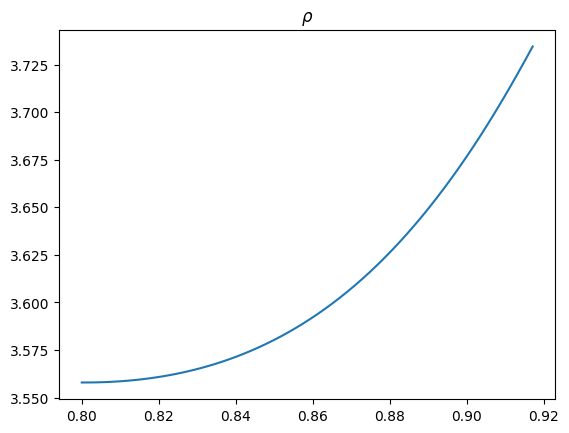

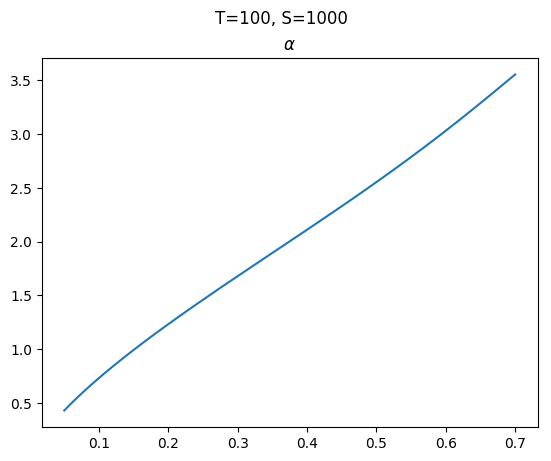

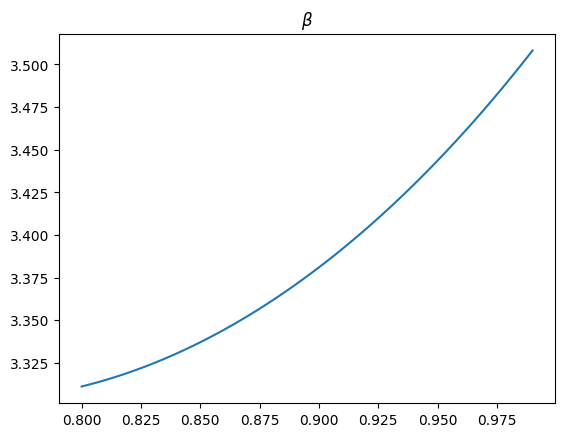

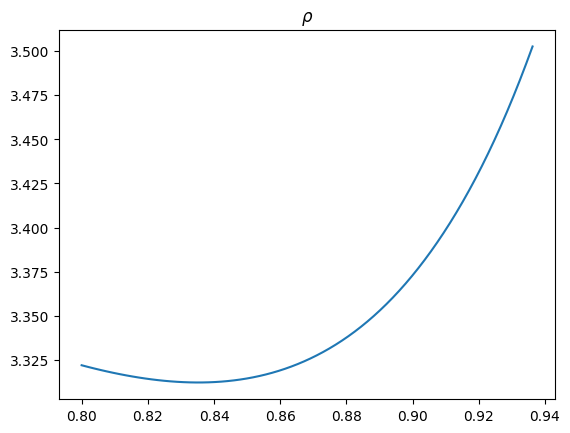

In [28]:
plot_stuf(res_t50_s100; titl="T=50, S=100", T=50);
plot_stuf(res_t50_s1000; titl="T=50, S=1000", T=50);
plot_stuf(res_t100_s100; titl="T=100, S=100", T=100);
plot_stuf(res_t100_s1000; titl="T=100, S=1000", T=100);